In [ ]:
# essential imports
import pandas as pd
import re
import yahooquery as yq
import datetime
import numpy as np

# imports for the models
import scipy.stats as st
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots


In [ ]:
# Leggi il file CSV
df = pd.read_csv('./data/tesi28.csv', sep=';')
#pulisci i nome dei df
# sostituisci gli spazi con _ e togli le parentesi
df.columns = [re.sub(r'\(.*\)', '', col) for col in df.columns]
# Rimuovere lo spazio dagli header delle colonne alla fine e tra le parole
df.columns = df.columns.str.rstrip(' ')
df.columns = df.columns.str.rstrip('.')
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/', '_')
df.columns = df.columns.str.replace('.', '')
df

## scarica i valori di borsa per ogni ticker, per ogni anno

In [ ]:
tickers = df['Ticker_symbol']
valori_borsa = []
tickers_non_scaricati=[]

# Scarica i dati storici per ciascun ticker e anno
for ticker in tickers:
    yq_ticker = yq.Ticker(ticker+".mi")
    for year in range(2023, 2013, -1):
        # Specifica la data desiderata come "YYYY-MM-DD" (31 dicembre dell'anno specificato)
        datainizio = f"{year}-01-01"
        datafine = f"{year}-01-10"
        print(ticker, year)
        # Converti la data desiderata in un oggetto datetime
        datainizio = datetime.datetime.strptime(datainizio, "%Y-%m-%d").date()
        datafine = datetime.datetime.strptime(datafine, "%Y-%m-%d").date()


        try:
            val = yq_ticker.history(start=datainizio, end=datafine)['close'][-1]
        except Exception as e:
            print(e.__cause__)
            val = "NaN"
            tickers_non_scaricati.append(ticker)

        print(ticker, val)
        valori_borsa.append(val)



In [ ]:
print(len(valori_borsa))
tickers_non_scaricati = set(tickers_non_scaricati)
print(tickers_non_scaricati)

### crea grafico di settori delle varie aziende

In [ ]:
tickers_list = list(tickers)
#print(tickers_list)
stocks_info = []
non_processed = []
for ticker in tickers_list:
    ticker = ticker+".mi"
    #print(ticker)
    yf_ticker = yq.Ticker(ticker)
    try:
        stocks_info.append({
            'ticker'    : ticker,
            'name'      : yf_ticker.quote_type[ticker]['shortName'],
            'industry'  : yf_ticker.asset_profile[ticker]['industry'],
            'sector'    : yf_ticker.asset_profile[ticker]['sector'],
        })
    except:
        non_processed.append(ticker)

print(non_processed)
t = pd.DataFrame(stocks_info)
t['name']

crea df per visualizzare industrie e settori

In [ ]:
sectors = pd.DataFrame(pd.DataFrame(t['sector'].value_counts())['count'])
industries = pd.DataFrame(pd.DataFrame(t['industry'].value_counts())['count'])
print(sectors)
print(industries)


visualizza industrie e settori

In [ ]:
fig_sectors = px.pie(sectors, values='count', names=sectors.index, title="settori")
fig_industry = px.pie(industries, 
                    values="count",
                    names=industries.index, 
                    title="industrie",
                    height=600,
                    )
fig_sectors.show()
fig_industry.show()


## crea nuovo df
1. prendi info di interesse, moltiplica per ogni anno ogni osservazione 
2. aggiungi gli anni di interesse
3. doppio ciclo for: per ogni riga df originale prendi i primi nove valori e trasponi il risultato, passa ai prossimi nove (secondo ciclo)

#### crea df delle info 

In [ ]:
info = pd.concat([df.iloc[:, 0:5]] * 10)
info.sort_index(inplace=True)
info

#### crea colonna degli anni, aggiungi a info

In [ ]:
anni = [anno for anno in range(2022, 2012, -1)] * 28
info['Anni'] = anni
info

#### df degli indici

In [ ]:
# Rimuovi il carattere '\n' e tutti quelli che seguono dalle intestazioni delle colonne
df.columns = df.columns.str.replace(r'\n.*', '', regex=True)
df.columns = df.columns.str.rstrip('_')
nomi_colonne = df.columns.unique()[5:]
# prendi df di interesse, serve a semplificare gli indici
indici = df.iloc[:, 5:]
for i in indici.columns:
    print(i)
# crea nuovo df
new_df = pd.DataFrame()

col = 0
#per ogni set di 10 valori riga di df originario INDICI
for i in range(0, 140, 10):
    
    indice = []
    #per ogni riga AZIENDA
    for j in range(1,len(indici)+1):
        # prendi i nove valori, trasponili e aggiungili al vettore dell'indice considerato
        valori = indici.iloc[j-1:j, i:i+10].values[0]
        valori = valori.T.tolist()
        
        indice= indice + valori
        
    # aggiungi colonna a new_df con insert
    new_df.insert(col, nomi_colonne[col], indice)
    col += 1


for col in new_df.columns:
    new_df[col] = new_df[col].str.replace(',' , '.').astype(float)
    #print(type(X[col]))

new_df

#### aggiungi anche valori azionari

In [ ]:
# aggiungi i valori della borsa al df info
info['Valori_Borsa'] = valori_borsa
info

##### esegui il join dei due dataframe, resetta gli indici!!


In [ ]:
#resetta indici
info = info.reset_index(drop=True)
new_df = new_df.reset_index(drop=True)
#esegui il join
dati_puliti = info.join(new_df)
dati_puliti


### ESEGUI SE NON VUOI AZIENDE SENZA VALORI DI BORSA
##### ripulisci i dati, togli le aziende che non hanno valori di borsa per almeno un anno e calcola gli indici per ogni azienda
i valori di borsa non sono presenti in quanto alcune di queste aziende non erano quotate durante il periodo di analisi.

In [ ]:
# elimina le aziende tramite una maschera
tickers_non_scaricati = list(set(tickers_non_scaricati))
maschera = dati_puliti['Ticker_symbol'].isin(tickers_non_scaricati)
dati_puliti = dati_puliti[~maschera]
#df_pulito = df_pulito.drop(columns=["Unnamed: 0"])
dati_puliti

### ESEGUI PER SALVARE DF DELLE AZIENDE CHE NON HANNO ALCUNI VALORI DI BORSA
DF È PIÙ PICCOLO

In [ ]:
dati_puliti.to_csv("./data/dati_puliti.csv")

### ESEGUI PER SALVARE DF DI TUTTE LE AZIENDE

In [ ]:
dati_puliti.to_csv("./data/dati_puliti28.csv")

# CREA IL MODELLO
**attenzione** al path usato, esistono due file: uno con tutte le aziende (dati_puliti28) e uno con solo le aziende che contengono valori di borsa(dati_puliti)
stiamo effettuando una trasformazione logaritmica della variabile dipendente: valori_borsa

In [ ]:
df = pd.read_csv('./data/dati_puliti28.csv', sep=',')
df = df.drop(columns=["Unnamed: 0"])
#calcola i logaritmo dei valori di borsa
df['Valori_Borsa'] = np.log(df['Valori_Borsa'])
df

#### distribuzioni delle variabili

In [ ]:
# Crea una griglia 5x3 di subplot
fig = make_subplots(rows=5, cols=3)
car_indici = []
# Cicla attraverso le colonne a partire dalla 7a
for idx, col_name in enumerate(df.columns[7:]):
    # Calcola la riga e la colonna corrispondenti nella griglia 5x3
    row = idx // 3 + 1
    col = idx % 3 + 1

    # Aggiungi un grafico a questa posizione
    histogram = px.box(df, x=col_name, )
    fig.add_trace(histogram.data[0], row=row, col=col)

    # Aggiungi titoli agli assi x e y
    fig.update_xaxes(title_text=col_name, row=row, col=col)
    fig.update_yaxes(title_text='Frequenza', row=row, col=col)

    #calcola media, min, max, dev std, 
    car_indici.append({
        'indice' : col_name,
        'media'  : df[col_name].mean(),
        'min'    : df[col_name].min(),
        'max'    : df[col_name].max(),
        'dev std': df[col_name].std(),
        'curtosi': df[col_name].kurtosis(),
        'skew'   : df[col_name].skew()
        
    })

# Aggiungi un layout per personalizzare il titolo e le dimensioni
fig.update_layout(
    title='Distribuzioni degli indici',
    height=1000,  # Imposta l'altezza della griglia
    width=1200    # Imposta la larghezza della griglia
)

# Visualizza la griglia
fig.show()


In [ ]:
car_indici = pd.DataFrame(car_indici)
car_indici.set_index('indice')
car_indici.round(decimals=3)

##### mostra le correlazioni tra i valori di borsa e tutti gli indici

In [ ]:
import seaborn as sns
correlation_matrix = df.iloc[:, 6:].corr()
# Crea una maschera per nascondere la parte superiore della matrice
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Crea una figura per il grafico
plt.figure(figsize=(12, 8))

# Personalizza l'aspetto della heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", mask=mask, cmap=cmap)

# Visualizza il grafico
plt.show()

In [46]:
df['log_Valori_Borsa'] = df['Valori_Borsa']
df['Valori_Borsa'] = np.e**df['log_Valori_Borsa']
df

,ID,Ragione_sociale,Ticker_symbol,ISIN_number,Numero_CCIAA,Anni,Valori_Borsa,Indice_corrente,Indice_di_liquidità,Rotaz_cap_investito,...,Redditività_di_tutto_il_capitale_investito,Redditività_delle_vendite,Redditività_del_capitale_proprio,Indice_di_copertura_delle_immob,Costo_denaro_a_prestito,Oneri_finanz_su_fatt,Grado_di_copertura_degli_interessi_passivi,Debiti_v_banche_su_fatt,Debt_Equity_ratio,log_Valori_Borsa
0,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2022,12.300000,1.58,1.18,1.55,...,5.34,2.22,7.77,0.45,3.79,0.50,8.11,13.25,0.95,2.509599
1,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2021,18.820000,1.57,1.20,1.17,...,7.26,3.83,9.50,0.42,4.31,0.68,8.88,15.76,0.86,2.934920
2,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2020,17.799999,1.70,1.38,0.98,...,0.12,0.09,-1.25,0.37,1.60,0.57,5.90,35.37,1.29,2.879198
3,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2019,21.200001,1.46,1.16,1.46,...,13.31,5.88,19.42,0.33,2.15,0.40,19.02,18.59,1.04,3.054001
4,1.0,MARR S.P.A.,MARR,IT0003428445,RN0276618,2018,21.520000,1.67,1.34,1.54,...,14.36,5.92,20.32,0.20,1.87,0.35,20.30,18.72,0.94,3.068983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2017,3.760000,3.34,3.31,0.02,...,7.48,22.97,5.28,0.03,1.42,1.13,25.64,79.55,0.35,1.324419
276,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2016,3.322000,2.39,2.37,0.02,...,8.08,24.26,8.55,0.02,2.01,1.26,25.00,62.68,0.27,1.200567
277,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2015,4.342000,2.55,2.53,0.02,...,9.94,29.06,13.71,0.02,3.10,1.53,23.10,49.29,0.20,1.468335
278,28.0,BASIC NET S.P.A.,BAN,IT0001033700,TO0631153,2014,2.262000,2.23,2.21,0.02,...,9.28,25.64,12.34,0.02,9.10,2.33,13.82,25.64,0.10,0.816249


In [58]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

for indice in df.columns[7:]:
    # Creare una figura con subplots
    fig = make_subplots(rows=1, cols=2,)
    
    for tick_symbol in df['Ticker_symbol'].unique():
        # Filtrare il DataFrame per il Ticker_symbol corrente
        df_subset = df[df['Ticker_symbol'] == tick_symbol]
        
        # Creare lo scatter plot con i valori di borsa originali
        scatter1 = go.Scatter(x=df_subset[indice], y=df_subset["log_Valori_Borsa"], mode='markers', name=f'Ticker {tick_symbol}')
        
        # Aggiungere la traccia al primo subplot
        fig.add_trace(scatter1, row=1, col=1)
        
        # Creare lo scatter plot con i valori di borsa trasformati con il logaritmo
        scatter2 = go.Scatter(x=df_subset[indice], y=df_subset["Valori_Borsa"], mode='markers', name=f'Ticker {tick_symbol}')
        
        # Aggiungere la traccia al secondo subplot
        fig.add_trace(scatter2, row=1, col=2)
    
    # Aggiornare la disposizione del layout
    fig.update_layout(title_text=f'Relazione tra {indice} e Valori Borsa', showlegend=False)
    
    # Aggiungere le etichette degli assi y
    fig.update_yaxes(title_text='Log Valori Borsa', row=1, col=1)
    fig.update_yaxes(title_text='Valori Borsa', row=1, col=2)
    
    # Mostrare la figura
    fig.show()

    

# prepara il df

In [ ]:
# crea le variabili dummy
df_dummies = pd.get_dummies(df["Ticker_symbol"])
print(df_dummies)
# unsci le dummies al df
df_con_dummies = df.join(df_dummies)
df_con_dummies


In [ ]:
df_con_dummies.columns

Construct the regression equation. Note that we are leaving out one dummy variable so as to avoid perfect Multicollinearity between the 7 dummy variables. la dummy omessa è BAN 
#RIVEDI

### definisci le variabili da usare nel modello

In [ ]:
# definisce le var dipendenti e indipendenti
y_var_name = 'Valori_Borsa'
x_var_names =  [
    'Anni',
    'Indice_corrente', 
    'Indice_di_liquidità',
    'Rotaz_cap_investito', 
    'Rotaz_cap_cir_lordo',
    'Redditività_del_totale_attivo',
    'Redditività_di_tutto_il_capitale_investito',
    'Redditività_delle_vendite', 
    'Redditività_del_capitale_proprio',
    'Indice_di_copertura_delle_immob', 
    'Costo_denaro_a_prestito',
    'Oneri_finanz_su_fatt', 
    'Grado_di_copertura_degli_interessi_passivi',
    'Debiti_v_banche_su_fatt', 
    'Debt_Equity_ratio'
    ]

unit_names = [
    'MARR', 
    'PIA', 
    'BRE', 
    'DAN', 
    'BC', 
    'CLI', 
    'ELC', 
    'GPI', 
    'SRI',
    'ALA', 
    'ICF', 
    'ENV', 
    'MASI', 
    'SVS', 
    'STAR7', 
    'SCK', 
    'MARP', 
    'ITD',
    'VIM', 
    'MDC', 
    'ILP', 
    'CFL', 
    'FCM', 
    'FVI', 
    'PLT', 
    'LDB', 
    'FOS',
    'BAN'
    ]

#only_value = [x for x in unit_names if x not in tickers_non_scaricati]
#unit_names = only_value


### crea il modello

In [ ]:
lsdv_expr = y_var_name + ' ~ '
i = 0
for x_var_name in x_var_names:
    if i > 0:
        lsdv_expr = lsdv_expr + ' + ' + x_var_name
    else:
        lsdv_expr = lsdv_expr + x_var_name
    i = i + 1
for dummy_name in unit_names[:-1]:
    lsdv_expr = lsdv_expr + ' + ' + dummy_name
 
print('Regression expression for OLS with dummies=' + lsdv_expr)

In [ ]:
lsdv_model = smf.ols(formula=lsdv_expr, data=df_con_dummies)
lsdv_model_results = lsdv_model.fit()
print(lsdv_model_results.summary())

In [ ]:
robust_results = lsdv_model_results.get_robustcov_results(cov_type='HAC', maxlags=2, groups=df['ID'], time=df['Anni'])

print(robust_results.summary())

### errori

In [ ]:
errors = []

In [ ]:
# Ottieni le previsioni per tutte le righe nel dataframe
predictions = lsdv_model_results.predict()

# trasform predictions to the original scale and the share values
predictions = np.e**predictions
val_borsa = (np.e**df['Valori_Borsa']).dropna()
#val_borsa = df['Valori_Borsa'].dropna()

rmse = np.sqrt(mean_squared_error(val_borsa, predictions))
mae = mean_absolute_error(val_borsa, predictions)
rsquared = lsdv_model_results.rsquared

# Aggiungi i dati alla lista
errors.append({
    'Formula': 'log ' + lsdv_expr,
    'RMSE': rmse,
    'MAE': mae,
    'R-Squared': rsquared,
})


In [ ]:
pd.set_option('display.max_colwidth', 2500)
errors_df = pd.DataFrame(errors)

err = pd.read_csv("./data/errori.csv")
err

### residui

In [ ]:
previsioni = df[['ID','Ticker_symbol','Anni', 'Valori_Borsa']].dropna()
previsioni['Valori_Borsa'] = val_borsa
previsioni['predictions'] = predictions
#previsioni[previsioni['Ticker_symbol']=='LDB']
previsioni['residui'] = previsioni['Valori_Borsa'] - previsioni['predictions'] 
previsioni

In [ ]:
previsioni = df[['ID','Ticker_symbol','Anni', 'Valori_Borsa']].dropna()
previsioni['predictions'] = robust_results.predict()
previsioni['residui'] = previsioni['Valori_Borsa'] - previsioni['predictions'] 
previsioni

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

# Calcola le correlazioni a vari lag
lag_max = 6
correlations = []

for lag in range(1, lag_max+1):
    correlation = previsioni['residui'].autocorr(lag=lag)
    correlations.append(correlation)

# Calcola le bande di significatività
alpha = 0.05
nobs = len(previsioni)
z_critical = stats.norm.ppf(1 - alpha/2) / (nobs**0.5)
lower_band = [-z_critical] * lag_max
upper_band = [z_critical] * lag_max

# Crea un grafico ACF con bande di significatività
fig, ax = plt.subplots(figsize=(10, 5))

plot_acf(previsioni['residui'], lags=lag_max, ax=ax)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)  # Aggiunge una linea orizzontale a 0

# Aggiunge bande di significatività
ax.fill_between(range(1, lag_max+1), lower_band, upper_band, color='gray', alpha=0.2)

plt.title('Autocorrelation Function (ACF) dei Residui')
plt.show()


In [ ]:
import math
corrs = []
for i in range(0,10):
    
    previsioni['res_lag' + str(i)] = previsioni.groupby(['ID'])['residui'].shift(i)

    correlazione = previsioni['residui'].corr(previsioni['res_lag' + str(i)])
    err_std = 1.96*(1/math.sqrt(previsioni['res_lag' + str(i)].count()))
    corrs.append((correlazione - err_std ,
    correlazione ,
    correlazione + err_std))



In [ ]:
# Estrai i valori delle correlazioni e i range
correlazioni = [x[1] for x in corrs]
minimi = [x[0] for x in corrs]
massimi = [x[2] for x in corrs]

# Creare un DataFrame
corrs = pd.DataFrame({'Lag': range(1,len(correlazioni)+1), 'Correlazione': correlazioni, 'Minimo': minimi, 'Massimo': massimi})
# riportiamo solo 6 lag , oltre ha troppa incertezza
corrs = corrs[:6]
corrs

In [ ]:
import plotly.graph_objects as go

# Creare il grafico
fig = go.Figure()

# Aggiungere i valori di correlazione
fig.add_trace(go.Bar(x=corrs['Lag'], y=corrs['Correlazione'], name='Correlazione'))

# Aggiungere le linee per i range dell'intervallo di confidenza
fig.add_trace(go.Scatter(x=corrs['Lag'], y=corrs['Minimo'], mode='lines', name='Minimo'))
fig.add_trace(go.Scatter(x=corrs['Lag'], y=corrs['Massimo'], mode='lines', name='Massimo'))

# Aggiungere layout
fig.update_layout(title='Funzione di Autocorrelazione',
                  xaxis_title='Lag',
                  yaxis_title='Correlazione',
                  xaxis=dict(tickmode='array', tickvals=corrs['Lag'], ticktext=corrs['Lag']))

# Mostrare il grafico
fig.show()


crea grafico delle previsioni e residui per ogni azienda

In [ ]:

fig = px.line(previsioni, x="Anni", y="residui", color="Ticker_symbol",
              title="Relazione tra Anni e Residui del modello",
              labels={'residui': 'Residui', 'Anni': 'Anno'},
              height=750)

# Mostra il grafico
fig.show()

controllo omoschedasticità, se sono omogenei lungo x rispetto a y

In [ ]:
# Crea un grafico a dispersione dei residui rispetto alle previsioni
plt.scatter(previsioni['predictions'], previsioni['residui'])
plt.xlabel('Previsioni')
plt.ylabel('Residui')
plt.title('Grafico dei Residui vs. Valori previsti')
plt.show()

acf dei residui: controllo autocorrelazione

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf

acf_residui = sm.tsa.acf(previsioni['residui'], nlags=13)
plot_acf(acf_residui, title=f'ACF residui')


controllo normalità

In [ ]:
from scipy.stats import shapiro

# Esegue il test di Shapiro-Wilk
statistica, p_value = shapiro(previsioni['residui'])

# Stampa i risultati del test
print(f'Statistica del test di Shapiro-Wilk: {statistica}')
print(f'p-value del test di Shapiro-Wilk: {p_value}')

# Confronta il p-value con un livello di significatività (e.g., 0.05)
if p_value > 0.05:
    print("Non abbiamo sufficienti prove per rifiutare l'ipotesi che i residui seguano una distribuzione normale.")
else:
    print("Rifiutiamo l'ipotesi che i residui seguano una distribuzione normale.")


In [ ]:
# Crea il QQ-plot
sm.qqplot(previsioni['residui'], line='s')  # 's' indica una linea di riferimento per una distribuzione normale
plt.title('QQ-Plot dei Residui')
plt.show()

### covarianza tra errori e indici
#### quarta condizione

In [ ]:
# Crea una griglia 5x3 di subplot
fig = make_subplots(rows=5, cols=3)

# Cicla attraverso le colonne a partire dalla 7a
for idx, col_name in enumerate(df.columns[7:]):
    # Calcola la riga e la colonna corrispondenti nella griglia 5x3
    row = idx // 3 + 1
    col = idx % 3 + 1

    # Aggiungi un grafico a questa posizione
    scatter = px.scatter(df.dropna(), y=previsioni['residui'], x=col_name)
    fig.add_trace(scatter.data[0], row=row, col=col)

    # Aggiungi titoli agli assi x e y
    fig.update_xaxes(title_text=col_name, row=row, col=col)
    fig.update_yaxes(title_text='Errori', row=row, col=col)


# Aggiungi un layout per personalizzare il titolo e le dimensioni
fig.update_layout(
    title='residui vs indici',
    height=1000,  # Imposta l'altezza della griglia
    width=1200    # Imposta la larghezza della griglia
)

# Visualizza la griglia
fig.show()


/home/leonardo/Documenti/UNIFI/LAUREA/MATERIALE/hive/env_tesi/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:848: RuntimeWarning:

invalid value encountered in sqrt



[1.52228547e-02 3.60904704e-04 2.05810244e-04 6.28025123e-04
 9.43801404e-04 1.45247759e-03 1.26068551e-04 6.54297938e-04
 7.07633163e-05 1.49077406e-03 3.44328497e-03 5.69985755e-04
 3.32571486e-04 5.86414495e-08 2.06547878e-03 1.16846298e-03
 1.51140682e-03 1.46536661e-04 4.96367553e-03 7.98731507e-03
 9.91090546e-05 8.68952612e-04 1.34702738e-03 1.00692622e-04
 1.13590813e-03 2.49108426e-03 4.98133290e-03 6.73525846e-05
 2.82681369e-03 9.97943669e-03 3.83950808e-04 1.37296185e-03
 1.81767506e-02 2.03833430e-03 3.51703795e-03 5.63139340e-06
 1.93126085e-03 2.15423046e-03 2.12146676e-03 2.06323356e-02
 9.05730546e-03 1.25253968e-02 6.44910102e-03 7.69063018e-05
 7.70885015e-04 2.80752944e-06 9.83991326e-04 9.35889865e-03
 3.59692972e-03 4.16936993e-05 1.28050190e-04 7.60242058e-03
 1.70238324e-03 1.38702940e-03 7.27461395e-04 2.12047776e-03
 4.39305971e-06 1.80388184e-03 8.72874013e-06 3.94667708e-03
 7.39771896e-03 9.89682297e-07 4.28411079e-03 2.30981125e-03
 6.77190394e-03 7.308371

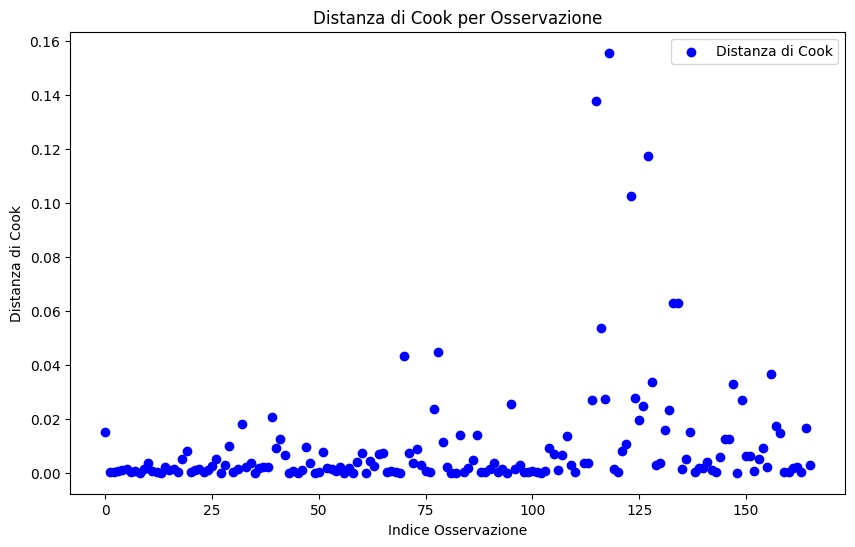

In [66]:


# Calcolare l'influenza e la distanza di Cook
influence = robust_results.get_influence()
cooks_distance = influence.cooks_distance

# Stampa i valori di distanza di Cook
print(cooks_distance[0])
# Creare un array con gli indici delle osservazioni
indices = range(len(cooks_distance[0]))

# Creare il grafico a dispersione
plt.figure(figsize=(10, 6))
plt.scatter(indices, cooks_distance[0], c='blue', label='Distanza di Cook')

# Aggiungere etichette e titoli
plt.xlabel('Indice Osservazione')
plt.ylabel('Distanza di Cook')
plt.title('Distanza di Cook per Osservazione')

# Mostrare il grafico
plt.legend()
plt.show()




In [76]:
previsioni['cook'] = cooks_distance[0]
previsioni

,ID,Ticker_symbol,Anni,Valori_Borsa,predictions,residui,res_lag0,res_lag1,res_lag2,res_lag3,res_lag4,res_lag5,res_lag6,res_lag7,res_lag8,res_lag9,cook
0,1.0,MARR,2022,2.509599,2.963589,-0.453990,-0.453990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015223
1,1.0,MARR,2021,2.934920,3.009185,-0.074265,-0.074265,-0.453990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000361
2,1.0,MARR,2020,2.879198,2.838172,0.041026,0.041026,-0.074265,-0.453990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000206
3,1.0,MARR,2019,3.054001,2.920100,0.133902,0.133902,0.041026,-0.074265,-0.453990,NaN,NaN,NaN,NaN,NaN,NaN,0.000628
4,1.0,MARR,2018,3.068983,2.901062,0.167921,0.167921,0.133902,0.041026,-0.074265,-0.453990,NaN,NaN,NaN,NaN,NaN,0.000944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,28.0,BAN,2017,1.324419,1.469303,-0.144884,-0.144884,-0.056466,0.078286,0.308739,0.257327,0.424789,NaN,NaN,NaN,NaN,0.001588
276,28.0,BAN,2016,1.200567,1.412986,-0.212419,-0.212419,-0.144884,-0.056466,0.078286,0.308739,0.257327,0.424789,NaN,NaN,NaN,0.002051
277,28.0,BAN,2015,1.468335,1.514338,-0.046003,-0.046003,-0.212419,-0.144884,-0.056466,0.078286,0.308739,0.257327,0.424789,NaN,NaN,0.000151
278,28.0,BAN,2014,0.816249,1.265864,-0.449615,-0.449615,-0.046003,-0.212419,-0.144884,-0.056466,0.078286,0.308739,0.257327,0.424789,NaN,0.016734


In [82]:
# Seleziona solo le colonne che ti interessano
df_plot = previsioni[['Ticker_symbol', 'cook']]

# Crea uno scatter plot
fig = px.scatter(df_plot, x=df_plot.index, y='cook', color='Ticker_symbol', 
                 title='Scatter plot della Distanza di Cook per Previsione', 
                 labels={'index': 'Indice Previsione', 'cook': 'Distanza di Cook'},
                 color_discrete_sequence=px.colors.qualitative.Plotly)

# Aggiungi titoli e etichette
fig.update_layout(xaxis_title='Indice Previsione', yaxis_title='Distanza di Cook', height=750)

# Mostra il grafico
fig.show()